## Standard Dataproc: Cluster Management with command line

This guide will walk you through everything you need to know to successfully run the Dataproc deployment models based on **Dataproc on Compute Engine** (This is the traditional model where you manage YARN-based clusters on Compute Engine VMs). We'll cover prerequisites, a breakdown of each argument, and best practices.

### Prerequisites:

* **Google Cloud Project:** You need an active Google Cloud Project.
* **Billing Enabled:** Billing must be enabled for your project.
* **APIs Enabled:** The Dataproc API, Compute Engine API, and Cloud Storage API must be enabled.
* **gcloud CLI Installed and Configured:** You've clearly done this as you're running gcloud commands.**Notice** You can run this commands in the Cloud Shell which is command-line access to your Google Cloud resources. 


### Create a cluster  
This is a comprehensive set of gcloud commands to prepare your project and then create the Dataproc cluster. 

In [ ]:
gcloud auth login

REGION=europe-west1
gcloud config set dataproc/region $REGION
PROJECT_ID=$(gcloud config get-value project) && \
gcloud config set project $PROJECT_ID

  * **`REGION = europe-west1`**: This line defines a shell variable `REGION` and sets its value to `europe-west1`. This makes the region easily reusable in subsequent commands.
  * **`gcloud config set dataproc/region $REGION`**: This command sets the default region for Dataproc operations in your `gcloud` configuration. This is convenient because you won't have to explicitly include `--region` in every `gcloud dataproc` command.
  * **`PROJECT_ID=$(gcloud config get-value project) && gcloud config set project $PROJECT_ID`**: These commands ensure that your `gcloud` CLI is configured to operate within the correct Google Cloud Project.
      * `$(gcloud config get-value project)` retrieves the currently active project ID.
      * `PROJECT_ID=...` assigns that value to a shell variable.
      * `gcloud config set project $PROJECT_ID` explicitly sets the project for your `gcloud` commands.

In [ ]:
PROJECT_NUMBER=$(gcloud projects describe $PROJECT_ID --format='value(projectNumber)')
gcloud projects add-iam-policy-binding $PROJECT_ID \
  --member=serviceAccount:$PROJECT_NUMBER-compute@developer.gserviceaccount.com \
  --role=roles/storage.admin
gcloud compute networks subnets update default --region=$REGION --enable-private-ip-google-access

  * **`PROJECT_NUMBER=$(gcloud projects describe $PROJECT_ID --format='value(projectNumber)')`**: This retrieves the numerical project number for your Google Cloud Project. This number is part of the default Compute Engine service account name.
  * **`gcloud projects add-iam-policy-binding ... --role=roles/storage.admin`**: This grants the `Storage Admin` role to the default Compute Engine service account (`<PROJECT_NUMBER>-compute@developer.gserviceaccount.com`).
      * **Why is this important?** Dataproc clusters use this service account (or a custom one if specified) for actions like reading and writing data to Cloud Storage. `roles/storage.admin` gives it broad permissions to manage objects and buckets. This is a common requirement for Spark/Hadoop jobs that interact with Cloud Storage.

In [ ]:
gcloud compute networks subnets update default --region=$REGION --enable-private-ip-google-access

  * **`gcloud compute networks subnets update default --region=$REGION --enable-private-ip-google-access`**: This command enables **Private Google Access** for the `default` subnetwork in your specified region (`europe-west1`).
      * **Why is this important, especially with `--no-address`?** When you use the `--no-address` flag with `gcloud dataproc clusters create`, it means your cluster VMs will **not** have external public IP addresses. This enhances security.
      * However, even without public IPs, your cluster VMs often need to communicate with Google Cloud APIs (like Dataproc control plane, Cloud Storage, Stackdriver Logging, etc.). Private Google Access allows VMs without external IP addresses to send traffic to Google API and service IP addresses through Google's internal network. Without it, `--no-address` clusters might fail to communicate with necessary Google services.
      * While enabling the feature itself is beneficial, using the default subnet for production workloads might be a point of architectural review for very mature or large-scale environments. In such scenarios, best practices often suggest Custom Subnets, which are Designing custom-mode VPC networks with dedicated subnets for different application tiers or environments (e.g., prod-web, prod-app, prod-db) for better network segmentation, isolation, and more granular security controls.

In [ ]:
# gcloud dataproc clusters create example-cluster \
#     --enable-component-gateway \
#     --worker-boot-disk-size 500 \
#     --image-version 2.2-debian12 \
#     --worker-machine-type=e2-standard-4 \
#     --master-machine-type=e2-standard-4 \
#     --no-address \
#     --optional-components=JUPYTER \
#     --labels=mode=workshop,user=zelda


gcloud dataproc clusters create example-cluster\
  --enable-component-gateway\
  --bucket=eurobet-dataproc-workshop\
  --region=europe-west1\
  --no-address\
  --master-machine-type=n4-standard-2\
  --master-boot-disk-type=hyperdisk-balanced\
  --master-boot-disk-size=100\
  --num-workers=2\
  --worker-machine-type=n4-standard-2\
  --worker-boot-disk-size=200\
  --image-version=2.2-debian12\
  --optional-components JUPYTER\
  --max-age=3600s\
  --labels=mode=workshop,user=zelda\
  --project=$PROJECT_ID

This is the core command to create your Dataproc cluster. Let's look at the new flags:

  * **`--enable-component-gateway`**: This explicitly enables the Component Gateway. While `--optional-components=JUPYTER` would typically enable it implicitly, this makes it explicit and ensures other component UIs are also accessible. The Component Gateway acts as a secure proxy to the web interfaces running on your cluster's master node (like Jupyter, YARN UI, Spark UI).
  * **`--image-version 2.2-debian12`**: it's recommended to specify an image version for consistency. `2.2-debian12` indicates a Dataproc image based on Debian 12 with Dataproc version 2.2.
  * **`--no-address`**: As discussed, this creates your cluster VMs without external public IP addresses, enhancing security. This flag requires Private Google Access to be enabled on the subnetwork, which you did in the previous step.
  * **`--optional-components=JUPYTER`**: This is the crucial flag that tells Dataproc to install Jupyter (and usually JupyterLab) on the cluster's master node. When you specify JUPYTER as an optional component, Dataproc automatically enables the Component Gateway as well, which is what allows you to access the web UI.
  * The other flags (**`--worker-boot-disk-size`**, **`--worker-machine-type`**, **`--master-machine-type`**) define the size and type of the virtual machines for your cluster.




### UseCase 1:  Jupyter Notebooks on DataProc

You've taken all the right steps for a secure and functional Dataproc cluster with Jupyter

1.  **Region and Project Setup:** Confirmed.
2.  **Storage Admin Permissions:** Granted for the compute service account, allowing Spark to interact with GCS.
3.  **Private Google Access:** Enabled, which is essential for `--no-address` clusters to communicate with Google services.
4.  **Cluster Creation:**
      * `example-cluster` created.
      * `--enable-component-gateway` for UI access.
      * Specific `2.2-debian12` image version used.
      * `--no-address` for enhanced security.
      * `JUPYTER` component included.

**How to open Jupyter Notebook in the UI (reiterating from previous answer for completeness):**

1.  **Go to the Google Cloud Console:** `https://console.cloud.google.com`
2.  **Navigate to Dataproc Clusters:** From the navigation menu (☰), go to **Analytics \> Dataproc \> Clusters**.
3.  **Select Your Cluster:** Click on the name of your cluster, `example-cluster`.
4.  **Go to "Web Interfaces" Tab:** On the cluster details page, click the **Web Interfaces** tab.
5.  **Click Jupyter/JupyterLab Link:** You will see a link for **Jupyter** or **JupyterLab**. Click on it to open the Jupyter interface in a new browser tab.


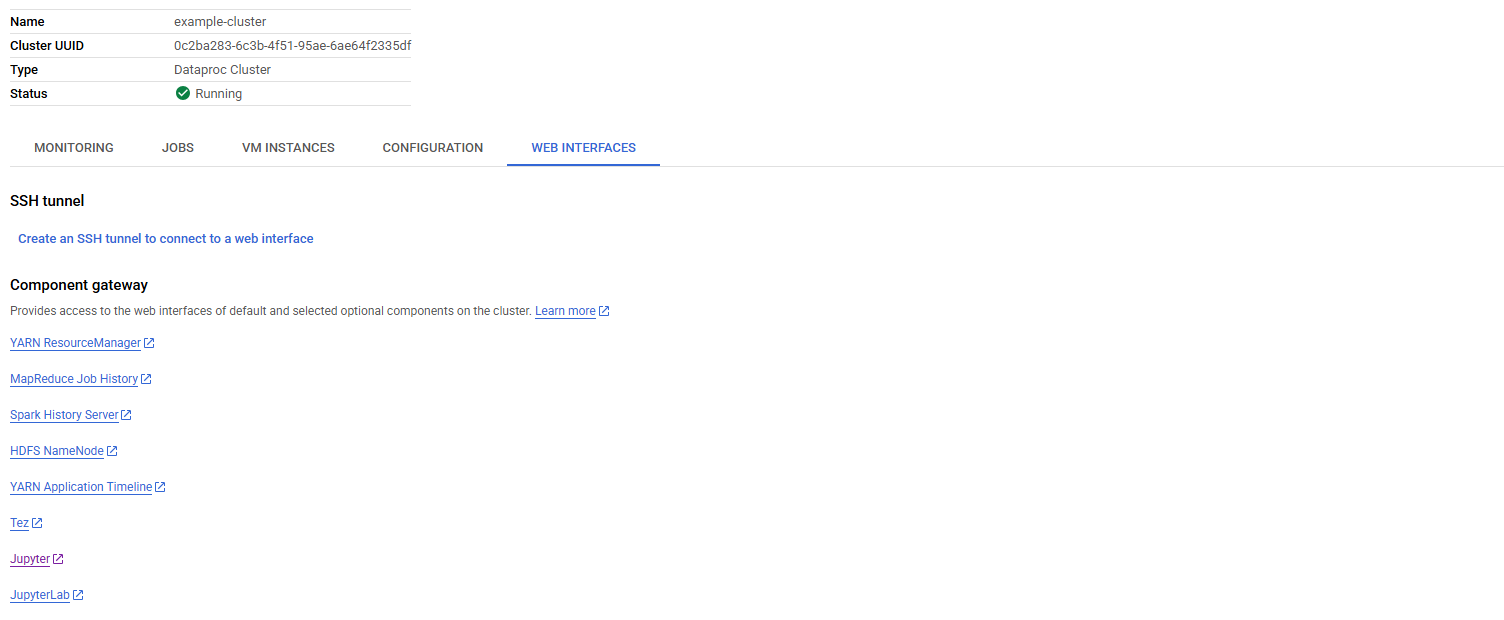


6.  **Create a New Notebook:**
    * In the Jupyter interface, select **New** -> **PySpark** (or Python 3, and ensure the PySpark kernel is available).

7.  **Paste and Run Your Code:**
    * Paste the code you provided into a cell in your new Jupyter Notebook.
    * **Crucially, ensure the CSV file(s) exist at the specified Cloud Storage path `gs://<BUCKET_NAME>/data/`**. If not, replace this path with the actual path to your CSV data.
    * Run the cell (Shift + Enter).



In [ ]:
from pyspark.sql import SparkSession

# Get or create a SparkSession
spark = SparkSession.builder.appName("MyDataprocNotebook").getOrCreate()

# Read a CSV file from a Cloud Storage bucket
# Replace 'bucket-name' and 'your-file.csv' with your actual bucket and file
df = spark.read.csv("gs://<BUCKET_NAME>/data/*.csv", header=True, inferSchema=True)

df.show()

### Update a cluster

You can update a running Google Cloud Dataproc cluster to modify its resources, primarily for scaling or managing metadata. The most common tool for this is the gcloud command-line interface.

It is important to understand that not all cluster properties can be updated. Core configurations like the machine type, image version, and network settings cannot be changed on a running cluster. For those changes, you must create a new cluster with the desired configuration.

Here are the most common update operations you can perform on a live Dataproc cluster:

#### **Scaling the Number of Worker Nodes:** 
This is the most frequent update operation, allowing you to add or remove worker nodes to adjust to your workload's demands (scaling out or in).


In [ ]:
gcloud dataproc clusters update your-cluster-name \
    --region=your-region \
    --num-workers=5

#### **Set a specific number of secondary (preemptible) workers:** 

To set a specific number of secondary (preemptible) workers, you use the `--num-secondary-workers` flag when creating your Dataproc cluster. These workers are cost-effective but can be preempted (shut down) by Google Cloud, making them suitable for fault-tolerant workloads.


In [ ]:

gcloud dataproc clusters create example-cluster \
    --region=us-central1 \
    --zone=us-central1-b \
    --master-machine-type=n1-standard-4 \
    --worker-machine-type=n1-standard-4 \
    --num-workers=2 \
    --num-secondary-workers=4 \
    --secondary-worker-machine-type=n1-standard-4 \
    --image-version=2.1-debian11 \
    --scopes=cloud-platform \
    --project=my-gcp-project-12345


**Explanation of New/Modified Parameters:**

  * **`--num-workers=2`**: This remains the number of **primary (on-demand) workers**. These workers are stable and not subject to preemption.
  * **`--num-secondary-workers=4`**: This is the new flag. It specifies that you want **4 secondary (preemptible) workers** in addition to your primary workers.
  * **`--secondary-worker-machine-type=n1-standard-4`**: (Optional, but good practice to specify if different from primary) This flag allows you to define the machine type for your secondary workers. In this example, it's the same as the primary workers, but you could use a different type if desired (e.g., smaller instances for burst capacity).

**Why use secondary (preemptible) workers?**

  * **Cost Savings:** Preemptible VMs are significantly cheaper (up to 80% off) than standard VMs.
  * **Scalability for Bursty Workloads:** They allow you to add a large amount of compute power for a fraction of the cost, ideal for jobs that can tolerate worker loss and retries (which Spark is generally good at).
  * **Improved Throughput:** More workers mean more parallel processing, potentially reducing job completion times for large datasets.

**Considerations when using secondary workers:**

  * **Preemption:** Secondary workers can be shut down by Google Cloud with a 30-second warning. Spark jobs should be designed to handle this gracefully (e.g., by recomputing lost partitions, which Spark's fault tolerance generally does automatically).
  * **Stateful Operations:** Avoid using secondary workers for highly stateful operations that would be severely impacted by worker loss.
  * **Driver Node:** Your master node (driver) should always be a primary (on-demand) VM.



####  **Using Graceful Decommissioning**
When scaling down, you can use graceful decommissioning to ensure that running tasks on the nodes being removed are not lost. This feature tells YARN to stop scheduling new tasks on those nodes and allows existing tasks to finish within a specified timeout.


In this example, Dataproc will wait up to 3600 seconds (1 hour) for the work on the nodes being removed to complete before shutting them down.

In [ ]:
gcloud dataproc clusters update your-cluster-name \
    --region=your-region \
    --num-workers=3 \
    --graceful-decommission-timeout=3600s

####  **Updating Labels**
Labels are key-value pairs that help you organize and manage your GCP resources, and assign costs based on a FinOps approach. You can add, update, or remove labels on a running cluster.

To add or update labels, this command will add these two labels or update their values if the keys already exist.


In [ ]:
gcloud dataproc clusters update your-cluster-name \
    --region=your-region \
    --update-labels=env=production,cost_center=research,user=zelda


To remove a label:

In [ ]:
!gcloud dataproc clusters update your-cluster-name \
    --region=your-region \
    --remove-labels=cost_center

####  **Updating Autoscaling Policies**
If you have an autoscaling policy attached to your cluster, you can update it to modify its scaling behavior. First, you might update the policy itself, and then you can re-apply it or attach a new one.

To attach or update the autoscaling policy for a cluster:

In [ ]:
gcloud dataproc clusters update your-cluster-name \
    --region=your-region \
    --update-autoscaling-policy=your-policy-id

Before you can use the update command, you must first create an Autoscaling Policy. This policy is a standalone resource in GCP that defines the logic for automatically adding or removing worker nodes from your cluster. The policy contains rules like:
1. **Scaling Limits:**
- The minimum number of workers the cluster must always have.
- The maximum number of workers the cluster is allowed to scale up to (to control costs).
2. **Scale-Up Rules (Adding Workers):** The trigger for adding more nodes. This is typically based on YARN metrics, like how much memory is pending for allocation. For example: "If the cluster needs more memory than is available for 1 minute, start adding workers."
3. **Scale-Down Rules (Removing Workers):** The trigger for removing idle nodes. For example: "If there are idle nodes with no running tasks for 10 minutes, start removing them."
4. **Cooldown Period:** A waiting period after a scaling action to prevent the cluster from scaling up and down too rapidly (known as "flapping").


The key benefit is that you can create one policy and apply it to multiple clusters, ensuring consistent scaling behavior everywhere.



**example**: This command creates a policy  named balanced-scaling-policy that keeps between 2 and 50 workers, scales up aggressively (adding 50% more workers when needed), and scales down cautiously (removing 10% of workers when idle).

In [ ]:
gcloud dataproc autoscaling-policies create balanced-scaling-policy \
    --region=your-region \
    --project=your-project-id \
    --set-basic-algorithm-yarn-config=graceful-decommission-timeout=300s,scale-up-factor=0.5,scale-down-factor=0.1 \
    --max-primary-workers=50 \
    --min-primary-workers=2


### Delete a cluster 

A **Google Dataproc cluster does not delete itself by default.** Once you create a standard cluster, it will continue to run and incur costs until you manually delete it.

To have a cluster delete itself automatically, you must configure this behavior at the time of creation. There are two primary ways to do this:

#### **Scheduled Deletion (Based on Age)**
This feature automatically deletes the cluster after a specific amount of time has passed since its creation. It's like setting a self-destruct timer.

- **How it works:** You specify a maximum age for the cluster. Once the cluster reaches this age, Dataproc will automatically start the deletion process, regardless of whether it is running a job or is idle.
- **Use Case:** This is ideal for jobs with a predictable maximum runtime. For example, if you know your data processing task will never take more than 4 hours, you can set the max age to 4h to ensure you don't forget to delete it.
- **Command Flag:** --max-age
- **Example:** This command creates a cluster that will automatically delete itself after 4 hours.



In [ ]:
gcloud dataproc clusters create my-temp-cluster \
    --region=us-central1 \
    --max-age=4h \
    --num-workers=2
gcloud dataproc clusters delete example-cluster --region=europe-west1

#### **Deletion Based on Idle Time**
This feature automatically deletes the cluster after it has been "idle" (not running any jobs) for a specified period.
- **How it works:** Dataproc monitors the cluster for active jobs. If no jobs are running for the duration you set, the cluster is considered idle and the deletion process begins. If a new job is submitted, the idle timer resets.
- **Use Case:** This is perfect for ad-hoc or interactive clusters, like a cluster used for development or data exploration with a Jupyter notebook. You use it when you need it, and if you forget to shut it down, it will clean itself up after a period of inactivity.
- **Command Flag:** --max-idle
- **Example:** This command creates a cluster that will automatically delete itself after being idle for 30 minutes.


In [ ]:
gcloud dataproc clusters create my-interactive-cluster \
    --region=us-central1 \
    --max-idle=30m \
    --num-workers=2


**Summary of Differences**

| Feature	 | --max-age (Scheduled Deletion)	| --max-idle (Max Idle Time)  |
|---|---|----|
| Trigger	| Time since creation (cluster's age) | 	Time since the last job finished (idle duration)  |
| Ideal For	|  Batch jobs with predictable runtimes | 	Interactive, ad-hoc, or development clusters  |
| Behavior | 	Deletes even if a job is still running	| Only deletes when the cluster is not running jobs  |


A third, more advanced option is to use Dataproc Workflow Templates. In this approach, you define a series of jobs as a workflow, and the workflow template manages the entire lifecycle of a cluster specifically for that workflow: 

The workflow automatically creates a new, temporary cluster specifically for the jobs.
It runs all the specified jobs on that cluster.
Once the jobs are finished, it automatically deletes the cluster.
This is the most efficient method as the cluster exists only for the exact duration needed to run your workload.